### Import libraries

In [77]:
import pymysql
from sqlalchemy import create_engine
import pandas as pd
import getpass  # To get the password without showing the input
from sklearn.preprocessing import StandardScaler
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import Normalizer #SKlearn is the library for machine learning
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

import seaborn as sns
import datetime
from datetime import datetime

import warnings
warnings.filterwarnings('ignore')

#%matplotlib inline
# password = getpass.getpass() # I don't have a MySQL passowrd, so don't use this
connection_string = 'mysql+pymysql://root:@localhost/sakila'
engine = create_engine(connection_string)

## 2. Read the data into a Pandas dataframe

In [12]:
query = '''SELECT
        F.film_id,
        F.rental_duration, 
        F.rental_rate, 
        F.replacement_cost,
        F.length, 
        F.rating, 
        COUNT(R.rental_id) as num_rentals
FROM film F
LEFT JOIN inventory I USING (film_id)
LEFT JOIN rental R USING (inventory_id)
GROUP BY F.film_id;
'''

data = pd.read_sql_query(query, engine)
data.head()

,film_id,rental_duration,rental_rate,replacement_cost,length,rating,num_rentals
0,1,6,0.99,20.99,86,PG,24
1,2,3,4.99,12.99,48,G,7
2,3,7,2.99,18.99,50,NC-17,12
3,4,5,2.99,26.99,117,G,23
4,5,6,2.99,22.99,130,G,12


## 3. Analyze extracted features and transform them. You may need to encode some categorical variables, or scale numerical variables

In [13]:
data.shape

(1000, 7)

In [14]:
data['num_rentals'].value_counts()

16    54
21    52
13    52
15    51
17    49
14    47
19    45
9     44
18    43
20    43
0     42
22    39
11    39
10    38
7     38
8     36
12    36
23    35
24    34
6     31
25    27
27    26
26    24
30    16
29    15
5     14
28    11
31     9
32     5
4      3
34     1
33     1
Name: num_rentals, dtype: int64

In [15]:
data.isna().sum() # the data appears to be clean with no NaN values

film_id             0
rental_duration     0
rental_rate         0
replacement_cost    0
length              0
rating              0
num_rentals         0
dtype: int64

In [16]:
data.rating.unique() #what are the film categories we're working with?

array(['PG', 'G', 'NC-17', 'PG-13', 'R'], dtype=object)

In [17]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   film_id           1000 non-null   int64  
 1   rental_duration   1000 non-null   int64  
 2   rental_rate       1000 non-null   float64
 3   replacement_cost  1000 non-null   float64
 4   length            1000 non-null   int64  
 5   rating            1000 non-null   object 
 6   num_rentals       1000 non-null   int64  
dtypes: float64(2), int64(4), object(1)
memory usage: 54.8+ KB


### Perform transformations

In [18]:
#split numericals and categoricals
data_cat = data.select_dtypes(include = np.object)
data_num = data.select_dtypes(include = np.number)

In [19]:
# scale numerical features

transformer = MinMaxScaler().fit(data_num)
data_num_minmax = transformer.transform(data_num) 
data_num_norm = pd.DataFrame(data_num_minmax,columns= data_num.columns)
data_num_norm.head()

,film_id,rental_duration,rental_rate,replacement_cost,length,num_rentals
0,0.000000,0.75,0.0,0.55,0.287770,0.705882
1,0.001001,0.00,1.0,0.15,0.014388,0.205882
2,0.002002,1.00,0.5,0.45,0.028777,0.352941
3,0.003003,0.50,0.5,0.85,0.510791,0.676471
4,0.004004,0.75,0.5,0.65,0.604317,0.352941


In [20]:
# encode the categorical feature

data_cat_dumm = pd.get_dummies(data_cat, drop_first=True)
data_cat_dumm.head()

,rating_NC-17,rating_PG,rating_PG-13,rating_R
0,0,1,0,0
1,0,0,0,0
2,1,0,0,0
3,0,0,0,0
4,0,0,0,0


### EDA

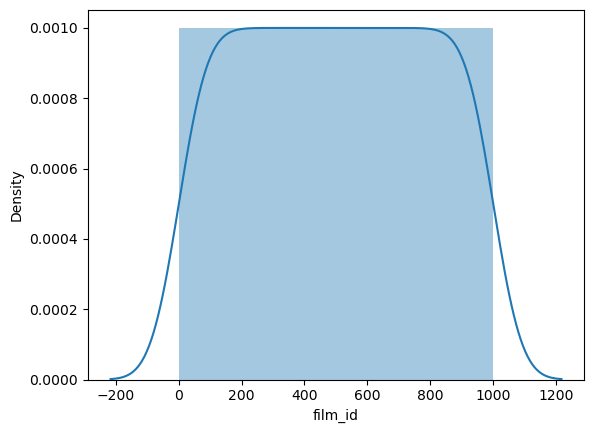

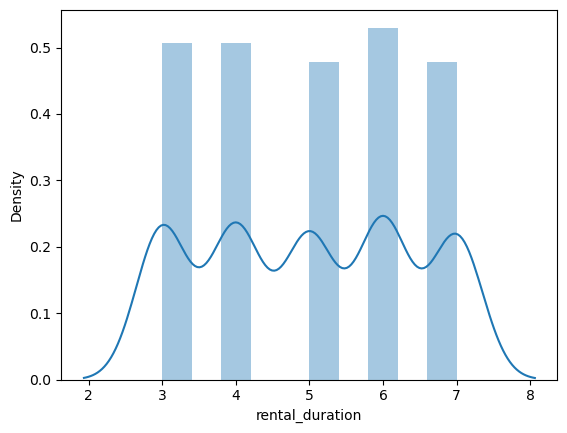

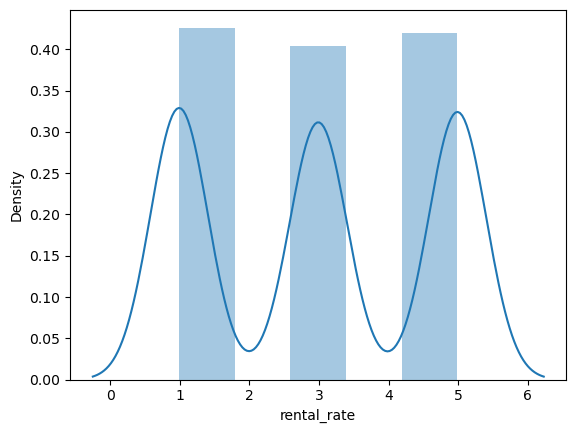

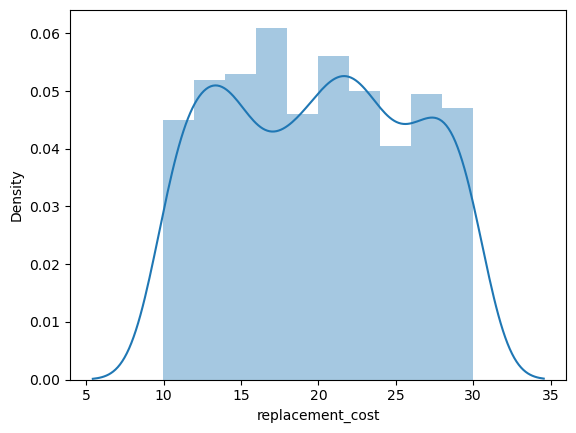

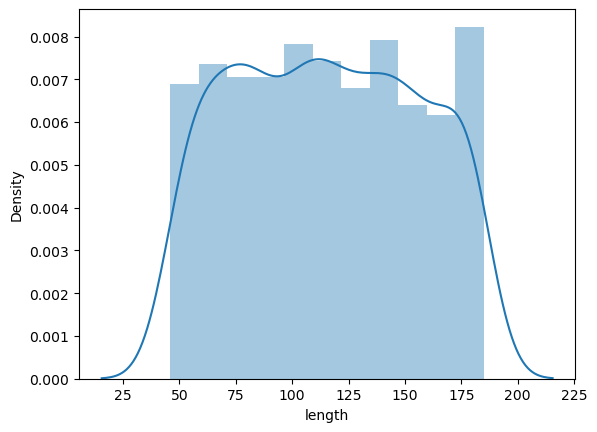

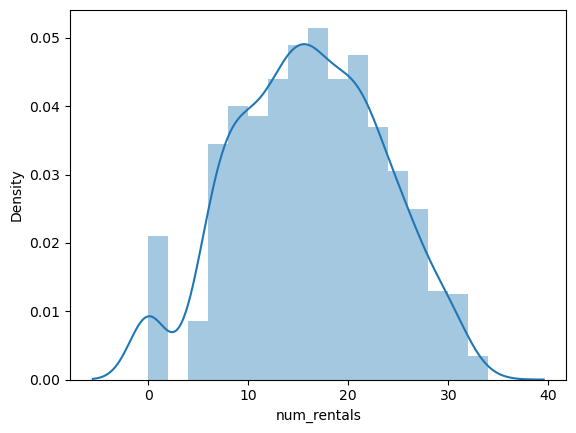

In [21]:
# visualise the numericals
for column in data_num.columns:
    sns.distplot(data_num[column])
    plt.show()

In [22]:
data_cat.describe

<bound method NDFrame.describe of     rating
0       PG
1        G
2    NC-17
3        G
4        G
..     ...
995      G
996  NC-17
997  NC-17
998      R
999  NC-17

[1000 rows x 1 columns]>

In [23]:
# we only have 1 categorical 

count_rating = data_cat.value_counts()
count_rating

rating
PG-13     223
NC-17     210
R         195
PG        194
G         178
dtype: int64

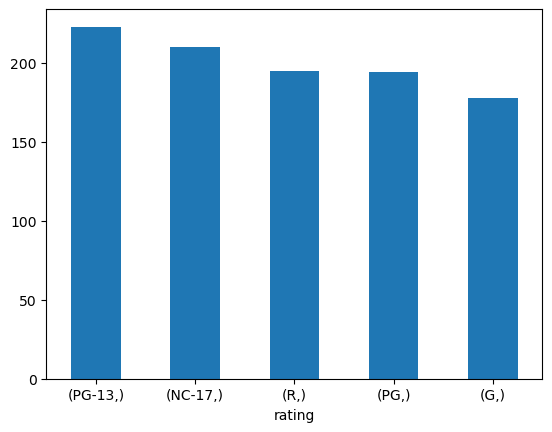

In [24]:
# we can use a barplot to view the data

ax = count_rating.plot.bar(x='rating', y='count', rot=0)

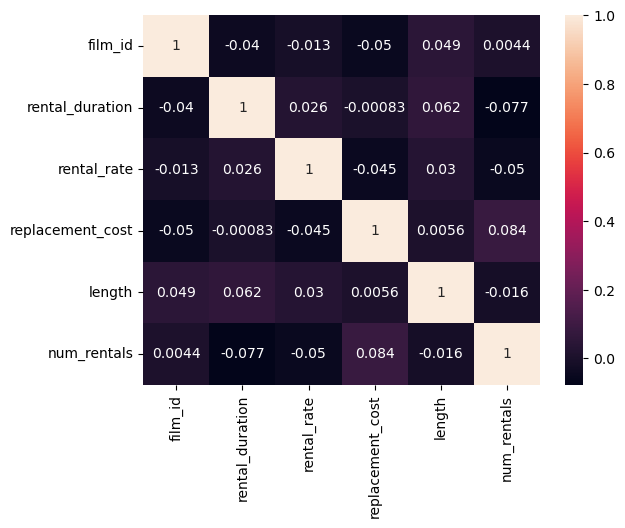

In [26]:
#use a correlation matrix to see the relationships between variables

corr_matrix = data_num.corr()
sns_plot = sns.heatmap(corr_matrix, annot=True)
plt.show()

# we see low correlation between variables

In [27]:
#concat the dataframes 

X = pd.concat([data_num_norm, data_cat_dumm], axis = 1)
X.head()

,film_id,rental_duration,rental_rate,replacement_cost,length,num_rentals,rating_NC-17,rating_PG,rating_PG-13,rating_R
0,0.000000,0.75,0.0,0.55,0.287770,0.705882,0,1,0,0
1,0.001001,0.00,1.0,0.15,0.014388,0.205882,0,0,0,0
2,0.002002,1.00,0.5,0.45,0.028777,0.352941,1,0,0,0
3,0.003003,0.50,0.5,0.85,0.510791,0.676471,0,0,0,0
4,0.004004,0.75,0.5,0.65,0.604317,0.352941,0,0,0,0


## 4. Create a query to get the list of films and a boolean indicating if it was rented last month. This would be our target variable.

In [32]:
# this was the first attempt but Python doesn't recognise 'Y'

query = '''SELECT
    date_format(CONVERT(R.rental_date, date), '%Y') as rental_year,
    date_format(CONVERT(R.rental_date, date), '%M') as rental_month, 
    COUNT(rental_id) AS num_rentals
FROM film F
LEFT JOIN inventory I USING (film_id)
LEFT JOIN rental R USING (inventory_id)
GROUP BY rental_year, rental_month;'''

# rentals = pd.read_sql_query(query, engine)
# rentals.head()

In [45]:
# this query filters out all the films from February in 2006
# the assumption I made for the question was that 'last month' means Feb 2006

query = '''
SELECT film_id, YEAR(rental_date) AS year, MONTH(rental_date) AS month
FROM film F
LEFT JOIN inventory I USING (film_id)
LEFT JOIN rental R USING (inventory_id)
WHERE MONTH(rental_date) = 02 
AND YEAR(rental_date) = 2006;
'''

#feb_rentals = pd.read_sql_query(query, engine)
#feb_rentals.head()

# the query doesn't work as it doesn't account for NaNs 

In [47]:
query = '''
WITH max_date as 
    (SELECT 
    F.film_id, 
    MAX(R.rental_date) as max_rental_date
FROM film F
LEFT JOIN inventory I USING (film_id)
LEFT JOIN rental R USING (inventory_id)
WHERE R.rental_date BETWEEN "2005-05-01 00:00:00" AND "2006-03-01 00:00:00"
GROUP BY F.film_id)
SELECT F.film_id, MD.max_rental_date AS rents_feb_2006
FROM (SELECT film_id, max_rental_date 
        FROM max_date 
        WHERE max_rental_date BETWEEN "2006-02-01 00:00:00" AND "2006-03-01 00:00:00") 
        AS MD
RIGHT JOIN film F
USING (film_id);
'''

feb_rentals = pd.read_sql_query(query, engine)
feb_rentals.head()

,film_id,rents_feb_2006
0,1,NaT
1,2,2006-02-14 15:16:03
2,3,NaT
3,4,2006-02-14 15:16:03
4,5,2006-02-14 15:16:03


In [48]:
feb_rentals.isna().sum()

film_id             0
rents_feb_2006    832
dtype: int64

In [49]:
feb_rentals.shape

(1000, 2)

In [50]:
# deal with NaN values

feb_rentals = feb_rentals.fillna(0)
feb_rentals["rents_feb_2006"] = feb_rentals["rents_feb_2006"].apply(lambda x: 1 if x != 0 else x)
feb_rentals["rents_feb_2006"].value_counts()

0    832
1    168
Name: rents_feb_2006, dtype: int64

In [51]:
# drop film_id so we are left with our target - month

y = feb_rentals.drop("film_id", axis = 1)
y

,rents_feb_2006
0,0
1,1
2,0
3,1
4,1
...,...
995,0
996,0
997,1
998,0


### 5. Create a logistic regression model to predict this variable from the cleaned data

In [52]:
# first step is the train-test split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 100)

In [56]:
len(X_train)

700

In [58]:
y_train

,rents_feb_2006
420,0
278,0
218,1
363,0
850,0
...,...
855,0
871,0
835,0
792,0


In [57]:
# use logisitc regression to train model

classification = LogisticRegression(random_state = 0).fit(X_train, y_train)

In [55]:
# predictions with testing dataset

predictions = classification.predict(X_test)

### 6. Evaluate the results

In [59]:
pd.Series(predictions).value_counts()

0    300
dtype: int64

In [60]:
y_test.value_counts()

rents_feb_2006
0                 251
1                  49
dtype: int64

In [70]:
cm1 = confusion_matrix(predictions, y_test)
cm

array([[251,   0],
       [ 49,   0]])

<AxesSubplot:>

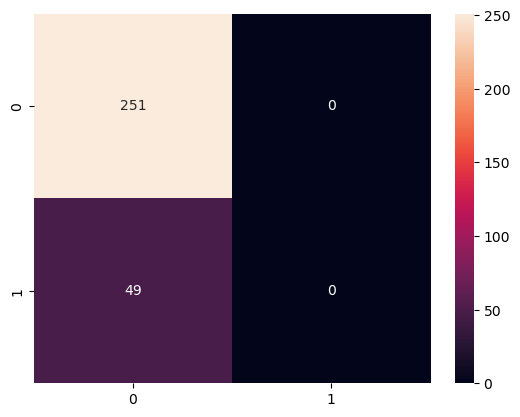

In [71]:
cm = confusion_matrix(y_test, predictions)
sns.heatmap(cm, annot=True,fmt='g')

<AxesSubplot:>

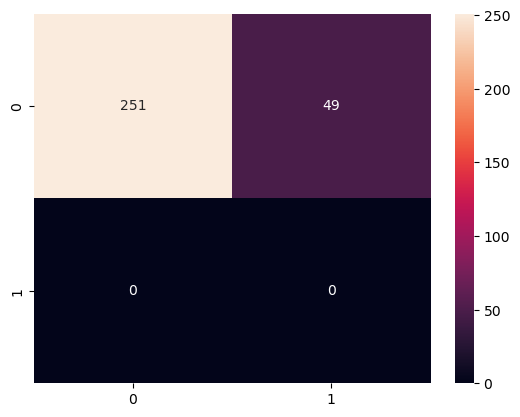

In [73]:
sns.heatmap(cm1, annot = True, fmt = 'g')

In [74]:
# accuracy

classification.score(X_test, y_test)

0.8366666666666667

In [79]:
# accuracy

print('\nAccuracy: {:.2f}\n'.format(accuracy_score(y_test, predictions)))


Accuracy: 0.84



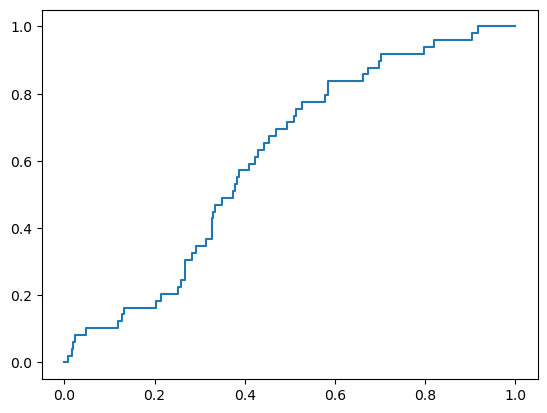

In [76]:
# Roc Curve - done by binarizing the target

from sklearn import metrics
import matplotlib.pyplot as plt

y_pred_proba = classification.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)
plt.plot(fpr,tpr)

In [53]:
actual = [0, 1, 1, 1] #these are the actual values
predicted = [0, 0, 1, 1]
df = pd.DataFrame(data = {"acutal":actual, "predicted":predicted})
df

,acutal,predicted
0,0,0
1,1,0
2,1,1
3,1,1


In [ ]:
cm = metrics.confusion_matrix(actual, predicted)

In [ ]:
sns.heatmap(cm, annnot = True)